### Getting Imports


In [ ]:
import requests
import pandas as pd
import re
from sqlalchemy import create_engine, inspect, text
import matplotlib.pyplot as plt
from abc import abstractmethod
from itertools import combinations
from dataclasses import dataclass
from backtesting import Backtest, Strategy
import os
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("api_key")

### Creating Database


In [ ]:


class PostgresManager:
    def __init__(self, host, port, dbname, user, password):
        self.db_params = {
            'host': host,
            'port': port,
            'dbname': dbname,
            'user': user,
            'password': password
        }
        self.engine_str = (
            f"postgresql://{user}:{password}@{host}:{port}/{dbname}"
        )
        self.engine = create_engine(self.engine_str)
        print("✅ PostgreSQL connection initialized.")

    def upload_dataframe(self, df: pd.DataFrame, table_name: str, if_exists='replace'):
        """
        Uploads a DataFrame to PostgreSQL.
        - if_exists: 'replace', 'append', or 'fail'
        """
        try:
            df.to_sql(table_name, self.engine, if_exists=if_exists, index=False, method='multi')
            print(f"✅ Data uploaded to table '{table_name}'.")
        except Exception as e:
            print(f"❌ Failed to upload to '{table_name}': {e}")
    
    def getTicker30MinData(self, ticker: str) -> pd.DataFrame:
        """
        Retrieves 30-minute interval data for a given ticker from PostgreSQL
        """
        table_name = f"{ticker.upper()}_30MinData"
        try:
            query = f"SELECT * FROM \"{table_name}\""
            df = pd.read_sql_query(query, self.engine)
            
            # Convert 'date' column to datetime and set as index
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
                df.set_index('date', inplace=True)
                df.sort_index(inplace=True)
                print(f"✅ Retrieved {len(df)} rows of 30-min data for {ticker}")
            else:
                print(f"❌ 'date' column missing in table {table_name}")
            return df
        except Exception as e:
            print(f"❌ Failed to fetch data for {ticker}: {e}")
            return pd.DataFrame()
    def getTickerEODData(self, ticker: str) -> pd.DataFrame:
        """
        Retrieves EOD data for a given ticker from PostgreSQL
        """
        table_name = f"{ticker.upper()}_EOD_Data"
        try:
            query = f"SELECT * FROM \"{table_name}\""
            df = pd.read_sql_query(query, self.engine)
            
            # Convert 'date' column to datetime and set as index
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
                df.set_index('date', inplace=True)
                df.sort_index(inplace=True)
                print(f"✅ Retrieved {len(df)} rows of EOD data for {ticker}")
            else:
                print(f"❌ 'date' column missing in table {table_name}")
            return df
        except Exception as e:
            print(f"❌ Failed to fetch data for {ticker}: {e}")
            return pd.DataFrame()
        
    def get_tickers_from_30min_tables(self):
        """
        Extracts all tickers from tables that match the {ticker}_30MinData format.
        """
        try:
            inspector = inspect(self.engine)
            all_tables = inspector.get_table_names()
            pattern = re.compile(r'^(.*)_30MinData$', re.IGNORECASE)
            tickers = [match.group(1).upper() for table in all_tables if (match := pattern.match(table))]
            return tickers
        except Exception as e:
            print(f"❌ Failed to inspect tables: {e}")
            return []
    def get_tickers_from_EOD_tables(self):
        """
        Extracts all tickers from tables that match the {ticker}_30MinData format.
        """
        try:
            inspector = inspect(self.engine)
            all_tables = inspector.get_table_names()
            pattern = re.compile(r'^(.*)_EOD_Data$', re.IGNORECASE)
            tickers = [match.group(1).upper() for table in all_tables if (match := pattern.match(table))]
            return tickers
        except Exception as e:
            print(f"❌ Failed to inspect tables: {e}")
            return []
        
        
#example usage
pg = PostgresManager(
    host=os.getenv('host'),
    port=os.getenv('port'),
    dbname=os.getenv('dbname'),
    user=os.getenv('user'),
    password=os.getenv('password')
)   
# Get all tickers from 30-min tables
tickers = pg.get_tickers_from_30min_tables()
print("Tickers found:", tickers)

# Fetch 30-min data for a specific ticker
ticker_data = pg.getTicker30MinData('AAPL')
print(ticker_data.head())

✅ PostgreSQL connection initialized.
Tickers found: ['AVGO', 'MA', 'JNJ', 'PM', 'IBM', 'NOW', 'TBB', 'RTX', 'ADBE', 'SCHW', 'TMO', 'C', 'GILD', 'PANW', 'CMCSA', 'MU', 'APH', 'BX', 'ICE', 'WELL', 'AMT', 'BMYMP', 'SOJC', 'CEG', 'HCA', 'DUKB', 'IBKR', 'ELV', 'INTC', 'AJG', 'TDG', 'CVS', 'RSG', 'ORLY', 'MMM', 'DELL', 'SCCO', 'APO', 'ZTS', 'ECL', 'SNPS', 'RCL', 'BRK-B', 'NFLX', 'HD', 'TMUS', 'WFC', 'AXP', 'ISRG', 'VZ', 'TXN', 'SPGI', 'BSX', 'TJX', 'RCIT', 'PFE', 'COF', 'CRWD', 'LMT', 'COP', 'MSFT', 'BRK-A', 'ORCL', 'BAC', 'UNH', 'CVX', 'NVDA', 'TSLA', 'COST', 'ABBV', 'GE', 'ABT', 'MS', 'MRK', 'BKNG', 'CAT', 'BA', 'NEE', 'APP', 'AMAT', 'ADP', 'LOW', 'VRTX', 'LRCX', 'KKR', 'MSTR', 'PLD', 'CME', 'SOJE', 'SOJD', 'NKE', 'FI', 'SHW', 'EQIX', 'ABNB', 'PH', 'CI', 'CDNS', 'FTNT', 'AAPL', 'WMT', 'XOM', 'KO', 'CRM', 'MCD', 'DIS', 'GS', 'UBER', 'QCOM', 'AMGN', 'HON', 'DE', 'UNP', 'GEV', 'ANET', 'MMC', 'ADI', 'KLAC', 'SBUX', 'MO', 'BMY', 'SO', 'WM', 'DASH', 'CTAS', 'DUK', 'MCK', 'MCO', 'MDLZ', 'UPS', 'A

### First Strategy Class


In [29]:
class Strategy():
    def __init__(self, data, name, description):
        self.data = data
        self.name = name
        self.description = description

    

In [59]:
import pandas as pd
import numpy as np

class TradingStrategy:
    def __init__(self, data: pd.DataFrame):
        self.rawData = data.copy()
        self.data = data
        self.workingData = pd.DataFrame()
        
    def go(self):
        self.data = self.convertToEOD(self.data)
        #iterating over each row in the DataFrame
        for index, row in self.data.iterrows():
            signal = self.processRow(row)
            if signal is not None:
                self.orderManagement(signal)
            # Append the current row to the working data
            self.workingData = pd.concat([self.workingData, pd.DataFrame([row])], ignore_index=True)
            
        self.plotResults()
        
    def processRow(self, row):
        
        if len(self.workingData) < 2:
            return None

        # Calculate signal using only past data
        signal = self.calculateSignal()
        
        

        if signal is not None:
            return signal
        else:
            return None
        
    def calculateSignal(self):
        #If the return of the last 7 days is greater than the return of the last 30 days
        #then we sell, otherwise we buy
        
        if len(self.workingData) < 30:
            return None
        
        last_7_days_return = self.workingData['close'].iloc[-7:].pct_change().sum()
        last_30_days_return = self.workingData['close'].iloc[-30:].pct_change().sum()
        
        if last_7_days_return > last_30_days_return:
            return 'sell'
        else:
            return 'buy'
        
    def orderManagement(self, signal):
        last_row = self.workingData.iloc[-1]
        position = 1 if signal == 'buy' else -1
        return_of_stock = last_row['close'] / last_row['open'] - 1
        return_of_strategy = return_of_stock * position

        idx = last_row.name
        self.workingData.at[idx, 'signal'] = signal
        self.workingData.at[idx, 'return_of_stock'] = return_of_stock
        self.workingData.at[idx, 'return_of_strategy'] = return_of_strategy
        self.workingData.at[idx, 'position'] = position

        # Add rolling metrics
        window = 20  # you can make this dynamic
        if len(self.workingData) >= window:
            recent = self.workingData.iloc[-window:]
            sharpe = (
                recent['return_of_strategy'].mean() /
                recent['return_of_strategy'].std()
                if recent['return_of_strategy'].std() != 0 else np.nan
            )
            volatility = recent['return_of_strategy'].std()
            cov = recent[['return_of_strategy', 'return_of_stock']].cov().iloc[0, 1]
            var_stock = recent['return_of_stock'].var()
            beta = cov / var_stock if var_stock != 0 else np.nan

            self.workingData.at[idx, 'rolling_sharpe'] = sharpe
            self.workingData.at[idx, 'rolling_volatility'] = volatility
            self.workingData.at[idx, 'rolling_beta'] = beta
        
    def convertToEOD(self, data: pd.DataFrame) -> pd.DataFrame:
        #resetting the index so that we can access the date column
        data=data.copy()
        data = data.reset_index() 
        #converting the date column to datetime
        data['date'] = pd.to_datetime(data['date'])
        
        #getting rid of rows where the open is 0 or NaN
        data = data[data['open'].notna() & (data['open'] != 0)]
        
        #we get all the rows of the same date and different times
        #the open is the first open of that date and the close is the last close of that date
        #the volume is the sum of the volume of all the rows of that date
        data = data.groupby(data['date'].dt.date).agg({
            'open': 'first',
            'close': 'last',
            'volume': 'sum'
        }).reset_index()
        
        #renaming the date column to date
        data.rename(columns={'date': 'date'}, inplace=True)
        
        #not setting the date as index so that we can access it later
        #data.set_index('date', inplace=True)
        #sorting the data by date
        data.sort_values(by='date', inplace=True)
        #resetting the index so that we can access the date column
        data.reset_index(drop=True, inplace=True)
        
        print(data.head())  # Display the first few rows for verification
        #returning the data
        return data


    
    def calculateAdditionalMetrics(self):
        """Calculate cumulative returns and cumulative volatility for the strategy."""
        df = self.workingData

        # Ensure return_of_strategy column exists
        if 'return_of_strategy' not in df.columns:
            print("⚠️ 'return_of_strategy' column not found. Cannot calculate additional metrics.")
            return

        # Fill NaNs with 0 for accurate compounding
        df['return_of_strategy'] = df['return_of_strategy'].fillna(0)
        df['return_of_stock'] = df['return_of_stock'].fillna(0)

        # Cumulative returns
        df['cumulative_returns'] = (1 + df['return_of_strategy']).cumprod() - 1

        # Cumulative volatility (sum of rolling stds)
        if 'rolling_volatility' in df.columns:
            df['cumulative_volatility'] = df['rolling_volatility'].fillna(0).cumsum()
        else:
            df['cumulative_volatility'] = np.nan  # default to NaN if rolling volatility not yet calculated

        self.workingData = df  # update the main dataframe

    
    def plotResults(self):
        # Ensure additional metrics are calculated
        self.calculateAdditionalMetrics()

        df = self.workingData

        # 1. Price chart with buy/sell signals
        plt.figure(figsize=(14, 6))
        plt.plot(df.index, df['close'], label='Close Price', color='blue')
        buy_signals = df[df['signal'] == 'buy']
        sell_signals = df[df['signal'] == 'sell']
        plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal')
        plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal')
        plt.title('Close Price with Buy/Sell Signals')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

        # 2. Rolling Sharpe Ratio
        if 'rolling_sharpe' in df.columns:
            plt.figure(figsize=(14, 4))
            plt.plot(df.index, df['rolling_sharpe'], label='Rolling Sharpe', color='purple')
            plt.title('Rolling Sharpe Ratio (20-day)')
            plt.xlabel('Date')
            plt.ylabel('Sharpe Ratio')
            plt.grid()
            plt.tight_layout()
            plt.show()

        # 3. Rolling Volatility
        if 'rolling_volatility' in df.columns:
            plt.figure(figsize=(14, 4))
            plt.plot(df.index, df['rolling_volatility'], label='Rolling Volatility', color='orange')
            plt.title('Rolling Volatility (20-day)')
            plt.xlabel('Date')
            plt.ylabel('Volatility')
            plt.grid()
            plt.tight_layout()
            plt.show()

        # 4. Cumulative Returns
        if 'cumulative_returns' in df.columns:
            plt.figure(figsize=(14, 4))
            plt.plot(df.index, df['cumulative_returns'], label='Cumulative Returns', color='green')
            plt.title('Cumulative Strategy Returns')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Return')
            plt.grid()
            plt.tight_layout()
            plt.show()

        # 5. Cumulative Volatility
        if 'cumulative_volatility' in df.columns:
            plt.figure(figsize=(14, 4))
            plt.plot(df.index, df['cumulative_volatility'], label='Cumulative Volatility', color='red')
            plt.title('Cumulative Volatility')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Volatility')
            plt.grid()
            plt.tight_layout()
            plt.show()
        
        
        

✅ Retrieved 81963 rows of 30-min data for AAPL
         date    open    close     volume
0  2003-09-10  0.3973  0.39607  433862744
1  2003-09-11  0.3973  0.40286  407572804
2  2003-09-12  0.4019  0.40290   68132792
3  2003-09-15  0.4073  0.40020   88750088
4  2003-09-16  0.3966  0.39929  525951708


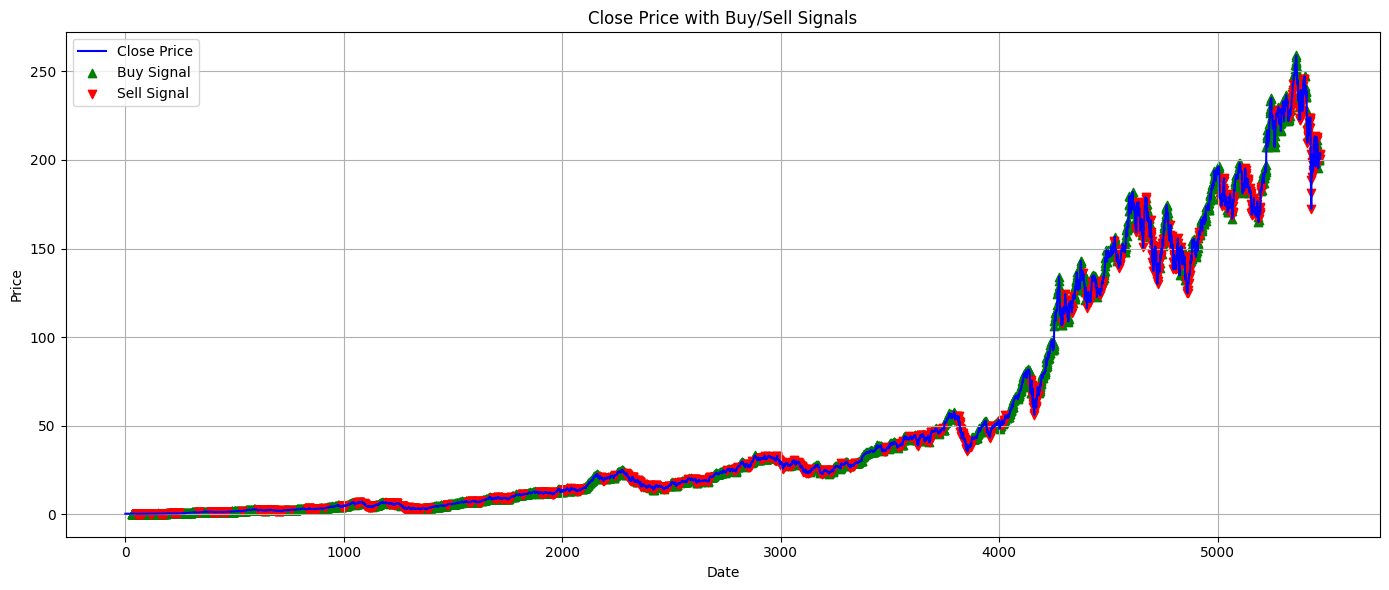

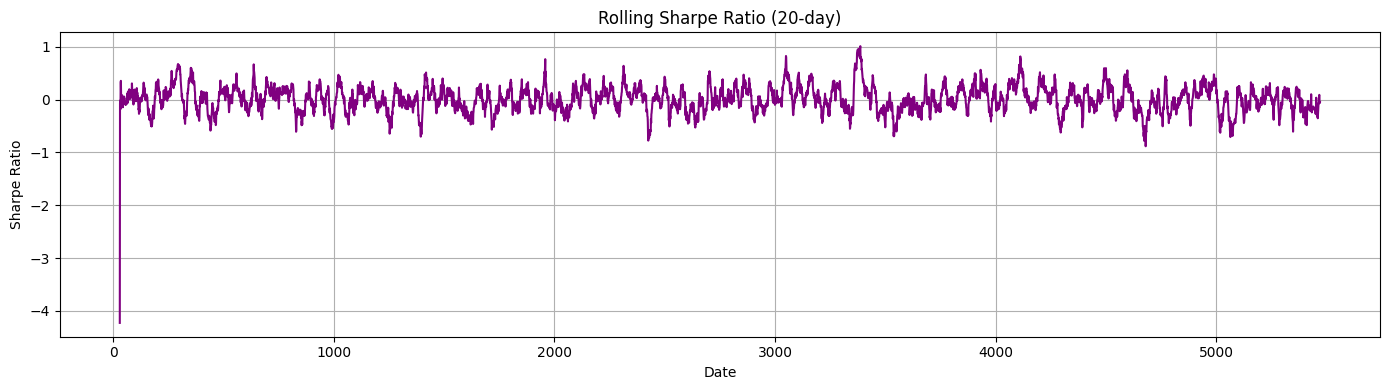

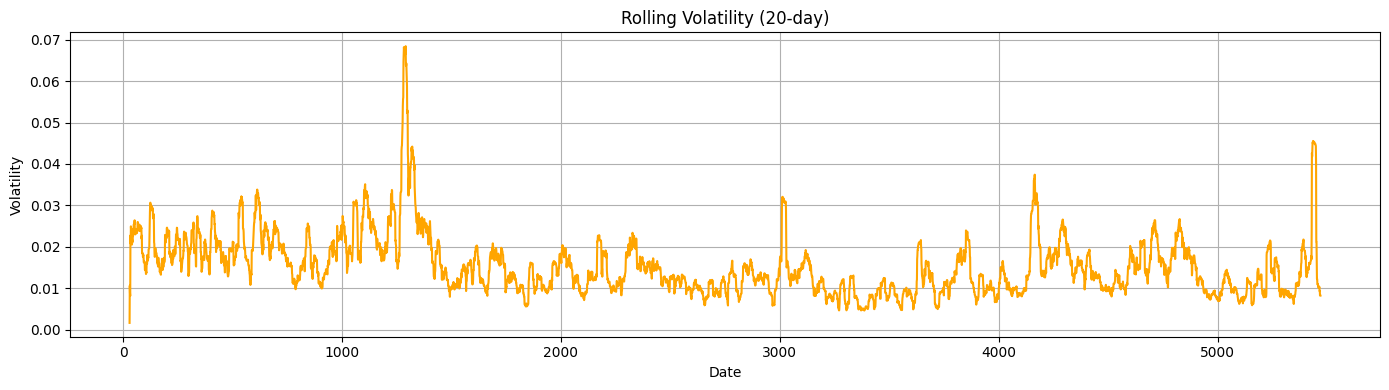

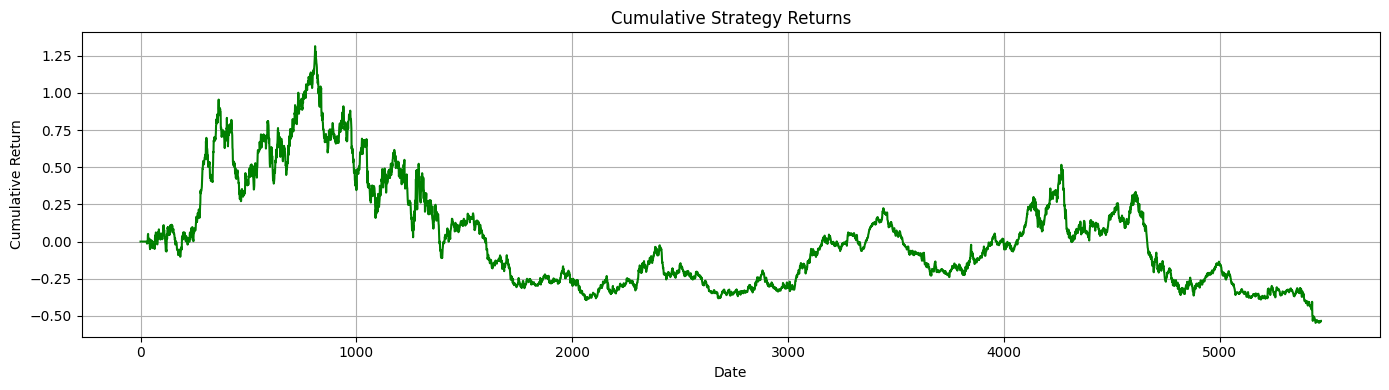

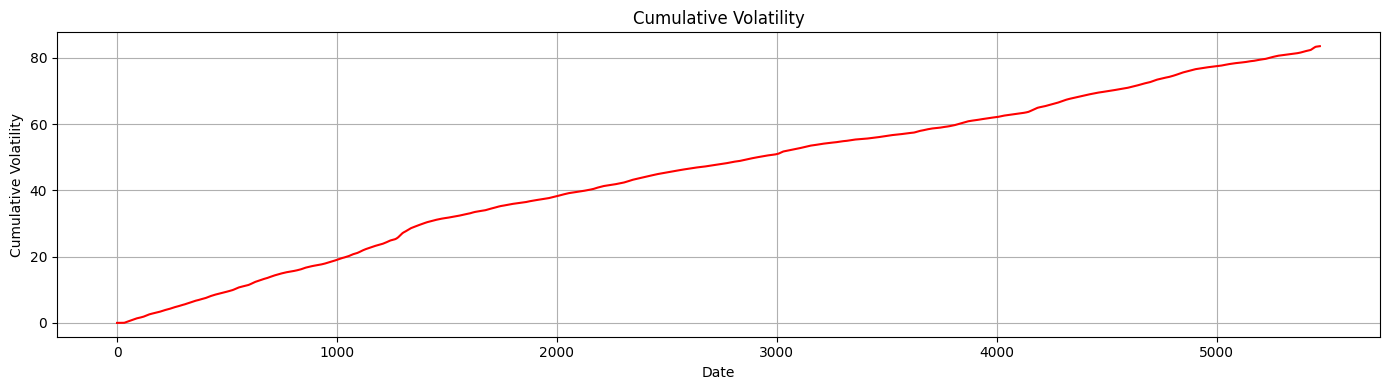

         date    open    close     volume signal  return_of_stock  \
0  2003-09-10  0.3973  0.39607  433862744    NaN              0.0   
1  2003-09-11  0.3973  0.40286  407572804    NaN              0.0   
2  2003-09-12  0.4019  0.40290   68132792    NaN              0.0   
3  2003-09-15  0.4073  0.40020   88750088    NaN              0.0   
4  2003-09-16  0.3966  0.39929  525951708    NaN              0.0   

   return_of_strategy  position  rolling_sharpe  rolling_volatility  \
0                 0.0       NaN             NaN                 NaN   
1                 0.0       NaN             NaN                 NaN   
2                 0.0       NaN             NaN                 NaN   
3                 0.0       NaN             NaN                 NaN   
4                 0.0       NaN             NaN                 NaN   

   rolling_beta  cumulative_returns  cumulative_volatility  
0           NaN                 0.0                    0.0  
1           NaN                 0.0 

In [60]:
#pulling the data from the database
ticker = 'AAPL'
data = pg.getTicker30MinData(ticker)
if data.empty:
    print(f"❌ No data found for {ticker}. Please check the database.")
else:
    # Initialize and run the trading strategy
    strategy = TradingStrategy(data)
    strategy.go()
    
    # Access the working data with all metrics
    working_data = strategy.workingData
    print(working_data.head())
    
    

### Getting Correlation


In [6]:



# 1. Get valid symbols from CompanyProfiles
query = """
SELECT symbol FROM "CompanyProfiles"
WHERE "marketCap" IS NOT NULL AND "marketCap" > 0
"""
symbols_df = pd.read_sql_query(text(query), pg.engine)
tickers = symbols_df['symbol'].tolist()

print(f"✅ Retrieved {len(tickers)} tickers with market cap > 0")

# 2. Get valid EODData tables that exist in the database
existing_tables = pg.get_tickers_from_EOD_tables()
valid_tickers = [t for t in tickers if t in existing_tables]

print(f"✅ {len(valid_tickers)} tickers with available EODData")

# 3. Load all 30-min data and clean
ticker_data = {}
for ticker in valid_tickers:
    table_name = f'"{ticker}_EOD_Data"'
    try:
        df = pd.read_sql_query(text(f"SELECT * FROM {table_name} WHERE open IS NOT NULL"), pg.engine)
        #checking if the length of the dataframe is greater than 0
        if df.empty:
            print(f"❌ No data found for {ticker} in {table_name}. Skipping.")
            continue
        df.reset_index(drop=True, inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        df = df[df['open'].notna() & (df['open'] != 0) & df['open'].notnull()]
        df.set_index('date', inplace=True)
        df = df[['close']]  # Only keep close for correlation
        df.rename(columns={'close': ticker}, inplace=True)
        ticker_data[ticker] = df
    except Exception as e:
        print(f"⚠️ Failed to load {ticker}: {e}")

# 4. Align on common earliest date
if not ticker_data:
    print("❌ No valid data to process.")
    
print(ticker_data)


✅ Retrieved 234 tickers with market cap > 0
✅ 233 tickers with available EODData
{'AVGO':               AVGO
date              
2009-08-06    1.62
2009-08-07    1.64
2009-08-10    1.60
2009-08-11    1.57
2009-08-12    1.60
...            ...
2025-06-02  248.71
2025-06-03  256.85
2025-06-04  261.08
2025-06-05  259.93
2025-06-06  246.93

[3984 rows x 1 columns], 'MA':                 MA
date              
2006-05-25    4.60
2006-05-26    4.49
2006-05-30    4.40
2006-05-31    4.49
2006-06-01    4.75
...            ...
2025-06-02  581.22
2025-06-03  581.97
2025-06-04  584.13
2025-06-05  585.44
2025-06-06  590.12

[4789 rows x 1 columns], 'JNJ':                JNJ
date              
1970-01-02    1.22
1970-01-05    1.19
1970-01-06    1.21
1970-01-07    1.21
1970-01-08    1.22
...            ...
2025-06-02  155.40
2025-06-03  154.42
2025-06-04  153.22
2025-06-05  153.66
2025-06-06  155.03

[14003 rows x 1 columns], 'PM':                 PM
date              
2008-03-17   49.39
2008-03-18   4

In [7]:
len(ticker_data)

233

In [8]:
TickerDataCopy = ticker_data.copy()
# Find common start date
# Filter out tickers where min_date is before 2010
min_dates = {ticker: df.index.min() for ticker, df in TickerDataCopy.items()}
filtered_TickerDataCopy = {ticker: df for ticker, df in TickerDataCopy.items() if min_dates[ticker] <= pd.Timestamp('2010-01-01')}
print(f"✅ Found {len(filtered_TickerDataCopy)} tickers with data starting from 2010 or later.")




if not filtered_TickerDataCopy:
    print("❌ No tickers with data starting from 2010 or later.")
TickerDataCopy = filtered_TickerDataCopy
##We go find out how many tickers have data at date 2010-01-01 specifically
#finding out how many tickers have a row with the date 2010-01-01
common_start = pd.Timestamp('2010-01-01')
min_dates = {ticker: pd.Timestamp(df.index.min()) for ticker, df in TickerDataCopy.items() if pd.Timestamp(df.index.min()) <= common_start}
if not min_dates:
    print("❌ No tickers with data starting from 2010-01-01.")
else:
    common_start = min(min_dates.values())
    TickerDataCopy = {ticker: df[df.index >= common_start] for ticker, df in TickerDataCopy.items() if df.index.min() <= common_start}
    print(f"✅ Found {len(min_dates)} tickers with data starting from 2010-01-01 or later.")
print(f"📅 Common start date for {len(min_dates)} stocks: {common_start.date()}")

# Trim all dataframes to start from common_start
for ticker in TickerDataCopy:
    TickerDataCopy[ticker] = TickerDataCopy[ticker][TickerDataCopy[ticker].index >= common_start]
    
# Print shapes of each ticker's data
for ticker, df in TickerDataCopy.items():
    print(f"📈 {ticker}: {df.shape[0]} rows from {df.index.min().date()} to {df.index.max().date()}")

# Merge all into one big DataFrame on date
merged_df = pd.concat(TickerDataCopy.values(), axis=1, join='inner').dropna()
print(f"📊 Final merged DataFrame shape: {merged_df.shape}")

# 5. Calculate correlation matrix
corr_matrix = merged_df.corr()

# 6. Rank and flatten correlations
correlation_ranks = {}
for t1, t2 in combinations(corr_matrix.columns, 2):
    corr_value = corr_matrix.loc[t1, t2]
    correlation_ranks[f"{t1}_{t2}_Corr"] = corr_value

# 7. Convert to ranked DataFrame
ranked_corrs = pd.DataFrame.from_dict(correlation_ranks, orient='index', columns=['correlation'])
ranked_corrs = ranked_corrs.sort_values(by='correlation', ascending=False)

print(ranked_corrs.head(10))



✅ Found 183 tickers with data starting from 2010 or later.
✅ Found 183 tickers with data starting from 2010-01-01 or later.
📅 Common start date for 183 stocks: 1962-01-02
📈 IBM: 15991 rows from 1962-01-02 to 2025-06-06
📈 MMM: 15990 rows from 1962-01-02 to 2025-06-06
📈 GE: 15966 rows from 1962-01-02 to 2025-06-06
📈 CAT: 15965 rows from 1962-01-02 to 2025-06-06
📈 BA: 15941 rows from 1962-01-02 to 2025-06-06
📈 KO: 15965 rows from 1962-01-02 to 2025-06-06
📈 DIS: 15965 rows from 1962-01-02 to 2025-06-06
📊 Final merged DataFrame shape: (15916, 7)
              correlation
MMM_DIS_Corr     0.938146
MMM_BA_Corr      0.915146
BA_DIS_Corr      0.912181
KO_DIS_Corr      0.902013
IBM_KO_Corr      0.898058
MMM_KO_Corr      0.897276
CAT_KO_Corr      0.865538
IBM_MMM_Corr     0.861566
BA_KO_Corr       0.840364
CAT_DIS_Corr     0.827649


In [9]:
len(ranked_corrs) 

21

### Creating Strategy Class


In [147]:



class MyStrategy():
    def __init__(self, data, name, description, constraints):
        self.rawData = data
        self.data = data
        self.name = name
        self.description = description
        self.workingData = pd.DataFrame()
        self.oms = OrderManagementSystem(constraints=constraints)
        self.constraints = constraints
        self.createProcessedData()
        
    @abstractmethod
    def createProcessedData(self):
        """
        This method should be implemented by subclasses to preprocess the raw data.
        It will be called to prepare the data for the strategy.
        """
        raise NotImplementedError("Subclasses must implement this method.")   
    @abstractmethod
    def go(self):
        """
        This method should be implemented by subclasses to define the trading logic.
        It will be called to execute the strategy.
        """
        raise NotImplementedError("Subclasses must implement this method.")    
    
    @abstractmethod
    def processRow(self, row, type='EOD'):
        """
        This method should be implemented by subclasses to define how each row of data is processed.
        It will be called for each row in the DataFrame.
        """
        raise NotImplementedError("Subclasses must implement this method.")
    
    @abstractmethod
    def go(self):
        """
        This method should be implemented by subclasses to define the main execution flow of the strategy.
        It will be called to run the strategy.
        """
        raise NotImplementedError("Subclasses must implement this method.")
    
    @abstractmethod
    def plotMetrics(self):
        """
        This method should be implemented by subclasses to convert the data to End of Day (EOD) format.
        It will be called to preprocess the data before running the strategy.
        """
        raise NotImplementedError("Subclasses must implement this method.")
    
    @abstractmethod
    def returnMetrics(self):
        """
        This method should be implemented by subclasses to return the metrics of the strategy.
        It will be called to retrieve the performance metrics after running the strategy.
        """
        raise NotImplementedError("Subclasses must implement this method.")
        
        

        # Here you would implement the actual trading logic

In [213]:
class MeanReversionStrategy(MyStrategy):
    def __init__(self, data, name="Mean Reversion Strategy", description="A strategy that trades based on mean reversion principles.", constraints=None, window = 30):
        super().__init__(data, name, description, constraints)
        self.window = window
        
    def createProcessedData(self):
        """
        Combines two ticker DataFrames into a single DataFrame with renamed columns.
        Processes the data to:
        1. Remove time component from dates
        2. Ensure both datasets have data up to 2025-06-06
        3. Join on date with column renaming (ticker_columnName format)
        """
        # Get the ticker names from rawData keys
        keys = list(self.rawData.keys())
        ticker1 = keys[0]
        ticker2 = keys[1]
        
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        
        # Process first ticker
        df1 = self.rawData[ticker1].copy()
        #resetting the index so that we can access the date column
        df1 = df1.reset_index()
        df1['date'] = pd.to_datetime(df1['date']).dt.date  # Remove time component
        df1 = df1[df1['date'] <= pd.to_datetime('2025-06-06').date()]  # Filter by end date
        
        # Process second ticker
        df2 = self.rawData[ticker2].copy()
        #resetting the index so that we can access the date column
        df2 = df2.reset_index()
        df2['date'] = pd.to_datetime(df2['date']).dt.date  # Remove time component
        df2 = df2[df2['date'] <= pd.to_datetime('2025-06-06').date()]  # Filter by end date
        
        #removing the symbol column if it exists
        if 'symbol' in df1.columns:
            df1 = df1.drop(columns=['symbol'])
        if 'symbol' in df2.columns:
            df2 = df2.drop(columns=['symbol'])
        # Rename columns for both DataFrames
        df1 = df1.rename(columns={
            'open': f'{ticker1}_open',
            'close': f'{ticker1}_close',
            'volume': f'{ticker1}_volume'
        })
        
        df2 = df2.rename(columns={
            'open': f'{ticker2}_open',
            'close': f'{ticker2}_close',
            'volume': f'{ticker2}_volume'
        })
        
        
        
        # Merge on date (inner join to ensure both have data for each date)
        combined = pd.merge(df1, df2, on='date', how='inner')
        
        # Set the combined data as the working data
        self.data = combined
        
        #initialize the workdingData with combined data columns
        self.workingData = pd.DataFrame(columns=combined.columns)
        #initialize the workingData in oms with the combined data columns
        self.oms.initWorkingData(combined.columns)
        
        
        # Optional: Set date as index if needed
        # self.workingData.set_index('date', inplace=True)
        
        
        
    def go(self):
        """
        This method should be implemented by subclasses to define the trading logic.
        It will be called to execute the strategy.
        """
        for index, row in self.data.iterrows():
            print(f"Processing row {index} for Mean Reversion Strategy")
            self.processRow(row)
            
            
    def updateWorkingData(self, row):
        """
        Updates the working data with the current row.
        This method is called for each row in the DataFrame.
        """
        # Append the current row to the working data
        self.workingData = pd.concat([self.workingData, pd.DataFrame([row])], ignore_index=True)
        self.updateWorkingDataMetrics()
        self.oms.addRow(row)
        
    def updateWorkingDataMetrics(self):
        """
        Updates working data with mean reversion metrics:
        1. Price ratio between the two tickers
        2. Rolling mean and std of the ratio (100-day window)
        3. Z-Score of current ratio
        4. Upper/lower bounds (mean ± 2*std)
        """
        if len(self.workingData) < 2:
            return  # Need at least 2 data points
        
        # Get ticker names (assuming they're stored or can be extracted)
        ticker1= self.ticker1  
        ticker2 = self.ticker2
        
        # Calculate price ratio (Ticker1/Ticker2)
        # Calculate rolling Z-Score for each ticker's close price
        self.workingData[f'{ticker1}_zscore'] = (
            (self.workingData[f'{ticker1}_close'] - self.workingData[f'{ticker1}_close'].rolling(self.window).mean()) /
            self.workingData[f'{ticker1}_close'].rolling(self.window).std()
        )
        self.workingData[f'{ticker2}_zscore'] = (
            (self.workingData[f'{ticker2}_close'] - self.workingData[f'{ticker2}_close'].rolling(self.window).mean()) /
            self.workingData[f'{ticker2}_close'].rolling(self.window).std()
        )
        # Ratio of the Z-Scores
        self.workingData['price_ratio'] = (
            self.workingData[f'{ticker1}_zscore'] /
            self.workingData[f'{ticker2}_zscore']
        )
        
        # Only calculate rolling metrics if we have enough data
        if len(self.workingData) >= self.window:
            # Calculate rolling statistics (self.window-day window)
            self.workingData['ratio_mean'] = self.workingData['price_ratio'].rolling(self.window).mean()
            self.workingData['ratio_std'] = self.workingData['price_ratio'].rolling(self.window).std()
            
            # Calculate Z-Score
            self.workingData['z_score'] = (
                (self.workingData['price_ratio'] - self.workingData['ratio_mean']) / 
                self.workingData['ratio_std']
            )
            
            # Calculate Bollinger-band like thresholds
            self.workingData['upper_bound'] = self.workingData['ratio_mean'] + 2*self.workingData['ratio_std']
            self.workingData['lower_bound'] = self.workingData['ratio_mean'] - 2*self.workingData['ratio_std']
        
        # Calculate additional metrics (your existing implementation)
        #self.calculateAdditionalMetrics()
    
    
    def processRow(self, row, type='EOD'):
        """
        This method should be implemented by subclasses to define how each row of data is processed.
        It will be called for each row in the DataFrame.
        """
        #check if the working data has at least self.window rows
        if not len(self.workingData) < self.window:
            # Calculate signal using only past data
            signal1 = self.calculateSignal1()
            signal2 = self.calculateSignal2()
            
            if signal1:
                self.oms.addOrder(signal1)
            if signal2 is not None:
                self.oms.addOrder(signal2)
        
        
        
        # Append the current row to the working data
        self.updateWorkingData(row)
        
    def calculateSignal1(self):
        """
        Generates signals for Ticker1 based on mean reversion of the price ratio.
        Returns: dict or None
        """
        if len(self.workingData) < self.window:
            return None
        
        current_z = self.workingData['z_score'].iloc[-1]
        current_ratio = self.workingData['price_ratio'].iloc[-1]
        ticker1 = self.ticker1
        
        entry_threshold = self.workingData['upper_bound'].iloc[-1]  # Upper bound for entry
        exit_threshold = self.workingData['lower_bound'].iloc[-1]  # Lower bound for exit
        
        # Mean reversion logic for Ticker1
        if current_z > entry_threshold:
            # Ticker1 is overvalued relative to Ticker2 → SELL signal
            return {
                'ticker': ticker1,
                'signal': 'sell',
                'price': self.workingData[f'{ticker1}_close'].iloc[-1],
                'z_score': current_z,
                'ratio': current_ratio,
                'type': 'mean_reversion'
            }
        elif current_z < exit_threshold:
            # Ticker1 is undervalued relative to Ticker2 → BUY signal
            return {
                'ticker': ticker1,
                'signal': 'buy',
                'price': self.workingData[f'{ticker1}_close'].iloc[-1],
                'z_score': current_z,
                'ratio': current_ratio,
                'type': 'mean_reversion'
            }
        elif abs(current_z) < exit_threshold :
            # Close position if ratio returns to mean
            return {
                'ticker': ticker1,
                'signal': 'close',
                'price': self.workingData[f'{ticker1}_close'].iloc[-1],
                'z_score': current_z,
                'type': 'mean_reversion_exit'
            }
        return None

    def calculateSignal2(self):
        """
        Generates signals for Ticker2 (inverse of Ticker1 signals).
        Returns: dict or None
        """
        if len(self.workingData) < self.window:
            return None
        
        current_z = self.workingData['z_score'].iloc[-1]
        current_ratio = self.workingData['price_ratio'].iloc[-1]
        ticker2 = self.ticker2
        
        entry_threshold = self.workingData['upper_bound'].iloc[-1]  # Upper bound for entry
        exit_threshold = self.workingData['lower_bound'].iloc[-1]  # Lower bound for exit
        
        # Inverse logic for Ticker2
        if current_z > entry_threshold:
            # Ticker2 is undervalued relative to Ticker1 → BUY signal
            return {
                'ticker': ticker2,
                'signal': 'buy',
                'price': self.workingData[f'{ticker2}_close'].iloc[-1],
                'z_score': current_z,
                'ratio': current_ratio,
                'type': 'mean_reversion'
            }
        elif current_z < exit_threshold:
            # Ticker2 is overvalued relative to Ticker1 → SELL signal
            return {
                'ticker': ticker2,
                'signal': 'sell',
                'price': self.workingData[f'{ticker2}_close'].iloc[-1],
                'z_score': current_z,
                'ratio': current_ratio,
                'type': 'mean_reversion'
            }
        elif abs(current_z) < exit_threshold :
            # Close position if ratio returns to mean
            return {
                'ticker': ticker2,
                'signal': 'close',
                'price': self.workingData[f'{ticker2}_close'].iloc[-1],
                'z_score': current_z,
                'type': 'mean_reversion_exit'
            }
        return None
     
    def orderManagement(self):
        """
        This method should be implemented by subclasses to define how orders are managed based on signals.
        It will be called when a signal is generated.
        """
        pass
    
    
    def plotMetrics(self):
        """
        This method should be implemented by subclasses to convert the data to End of Day (EOD) format.
        It will be called to preprocess the data before running the strategy.
        """
        pass
    
    
    def returnMetrics(self):
        """
        This method should be implemented by subclasses to return the metrics of the strategy.
        It will be called to retrieve the performance metrics after running the strategy.
        """
        pass
        
    

In [218]:
ticker1 = 'MMM'
ticker2 = 'BA'

# Fetching EOD data for the two tickers
df1 = pg.getTickerEODData(ticker1)
df2 = pg.getTickerEODData(ticker2)

# Only keep data after 2010 (date is the index)
df1 = df1[df1.index >= pd.Timestamp('2010-01-01')]
df2 = df2[df2.index >= pd.Timestamp('2010-01-01')]

# Initialize and run the Mean Reversion Strategy
data={ticker1: df1, ticker2: df2}

constraints = {
    'holdingPeriod': None,
    'stopLoss': 0.8,
    'takeProfit': None,
    'longOnly': False,
    'shortOnly': False,
}
strategy = MeanReversionStrategy(name = f"{ticker1}_{ticker2}_MeanReversion",data=data, constraints=constraints)
strategy.go()
    

✅ Retrieved 15990 rows of EOD data for MMM
✅ Retrieved 15941 rows of EOD data for BA
✅ Constraints updated: {'holdingPeriod': None, 'stopLoss': 0.8, 'takeProfit': None, 'longOnly': False, 'shortOnly': False}
✅ Working data initialized with columns: Index(['date', 'MMM_open', 'MMM_close', 'MMM_volume', 'BA_open', 'BA_close',
       'BA_volume'],
      dtype='object')
Processing row 0 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 1 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 2 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 3 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 4 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 5 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 6 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 7 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 8 for Mean Reversion Strategy
✅ No open 

/tmp/ipykernel_1467/1478147216.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.workingData = pd.concat([self.workingData, pd.DataFrame([row])], ignore_index=True)
/tmp/ipykernel_1467/821941003.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.workingData = pd.concat([self.workingData, pd.DataFrame([row])], ignore_index=True)


✅ No open orders to check.
Processing row 46 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 47 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 48 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 49 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 50 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 51 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 52 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 53 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 54 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 55 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 56 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 57 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 58 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 59 for Me

In [219]:
myWorkingData = strategy.oms.workingData.copy()

myWorkingData.tail(10)

,date,MMM_open,MMM_close,MMM_volume,BA_open,BA_close,BA_volume,MMM_position,MMM_return_of_stock,MMM_return_of_strategy,MMM_rolling_sharpe,MMM_rolling_volatility,MMM_rolling_beta,BA_position,BA_return_of_stock,BA_return_of_strategy,BA_rolling_sharpe,BA_rolling_volatility,BA_rolling_beta
3871,2025-05-23,147.45,147.62,2369839,199.95,202.36,5255200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3872,2025-05-27,150.00,149.49,3155330,204.28,201.03,5857940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3873,2025-05-28,149.65,148.66,2297543,201.95,201.50,5481504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3874,2025-05-29,149.87,149.63,2621435,201.78,208.18,16346000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3875,2025-05-30,148.73,148.35,5339916,206.77,207.32,7485100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3876,2025-06-02,147.87,146.40,2825788,210.98,211.47,7561816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3877,2025-06-03,146.31,148.13,2343553,212.00,213.43,8106100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3878,2025-06-04,148.91,146.81,2347013,214.77,211.98,5705300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3879,2025-06-05,147.04,146.26,3568399,212.50,209.02,4764400,0.989,-0.005305,-0.005246,NaN,NaN,NaN,-0.989,-0.016376,0.016196,NaN,NaN,NaN
3880,2025-06-06,148.00,145.50,2297132,210.24,210.80,6079682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [220]:
#getting all the unique values in BA_position
unique_positions = myWorkingData['MMM_position'].unique()
print("Unique positions in BA:", unique_positions)

Unique positions in BA: [   nan -0.989  0.989]


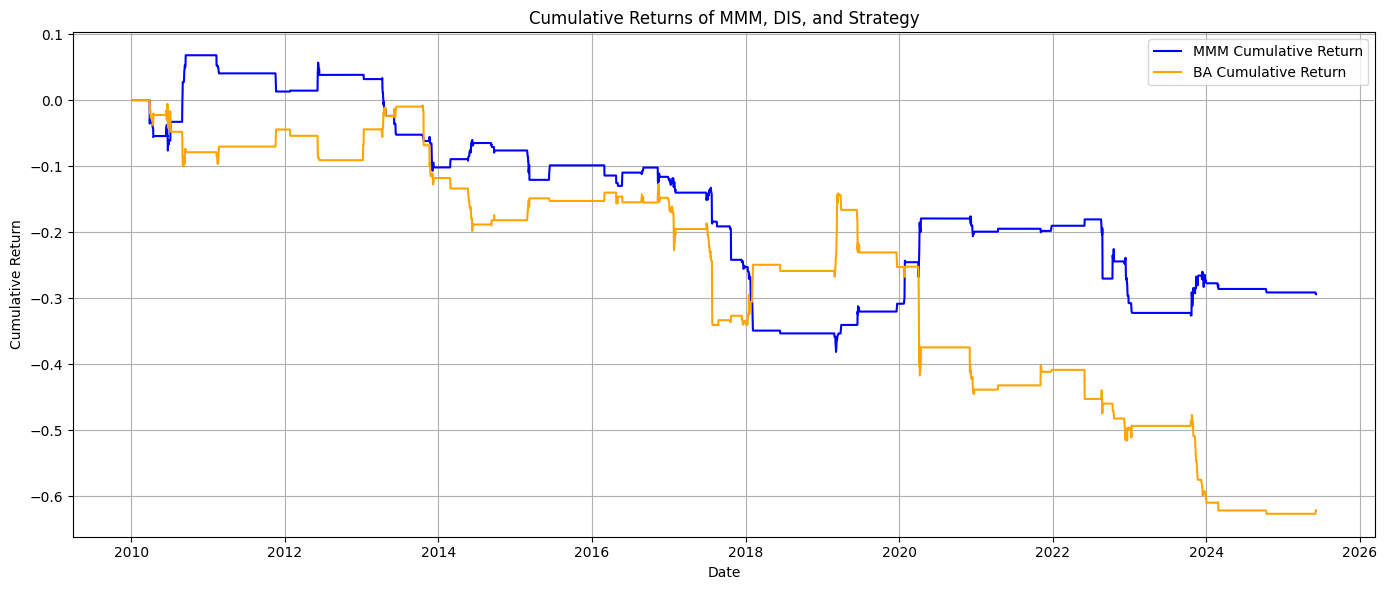

In [222]:
#fill in all the NaN values in the position column with 0
myWorkingData[f'{ticker1}_position'] = myWorkingData[f'{ticker1}_position'].fillna(0)
myWorkingData[f'{ticker2}_position'] = myWorkingData[f'{ticker2}_position'].fillna(0)

myWorkingData[f'{ticker1}_return_of_strategy'] = myWorkingData[f'{ticker1}_position'] * myWorkingData[f'{ticker1}_close'].pct_change()
myWorkingData[f'{ticker2}_return_of_strategy'] = myWorkingData[f'{ticker2}_position'] * myWorkingData[f'{ticker2}_close'].pct_change()

#getting the geometric returns of the stocks
myWorkingData[f'{ticker1}_cumulative'] = (1 + myWorkingData[f'{ticker1}_return_of_strategy']).cumprod() - 1
myWorkingData[f'{ticker2}_cumulative'] = (1 + myWorkingData[f'{ticker2}_return_of_strategy']).cumprod() - 1
#calculate the geometric rolling cumulative strategy_return
# Plot the cumulative returns
plt.figure(figsize=(14, 6))
plt.plot(myWorkingData['date'], myWorkingData[f'{ticker1}_cumulative'], label=f'{ticker1} Cumulative Return', color='blue')
plt.plot(myWorkingData['date'], myWorkingData[f'{ticker2}_cumulative'], label=f'{ticker2} Cumulative Return', color='orange')
plt.title('Cumulative Returns of MMM, DIS, and Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


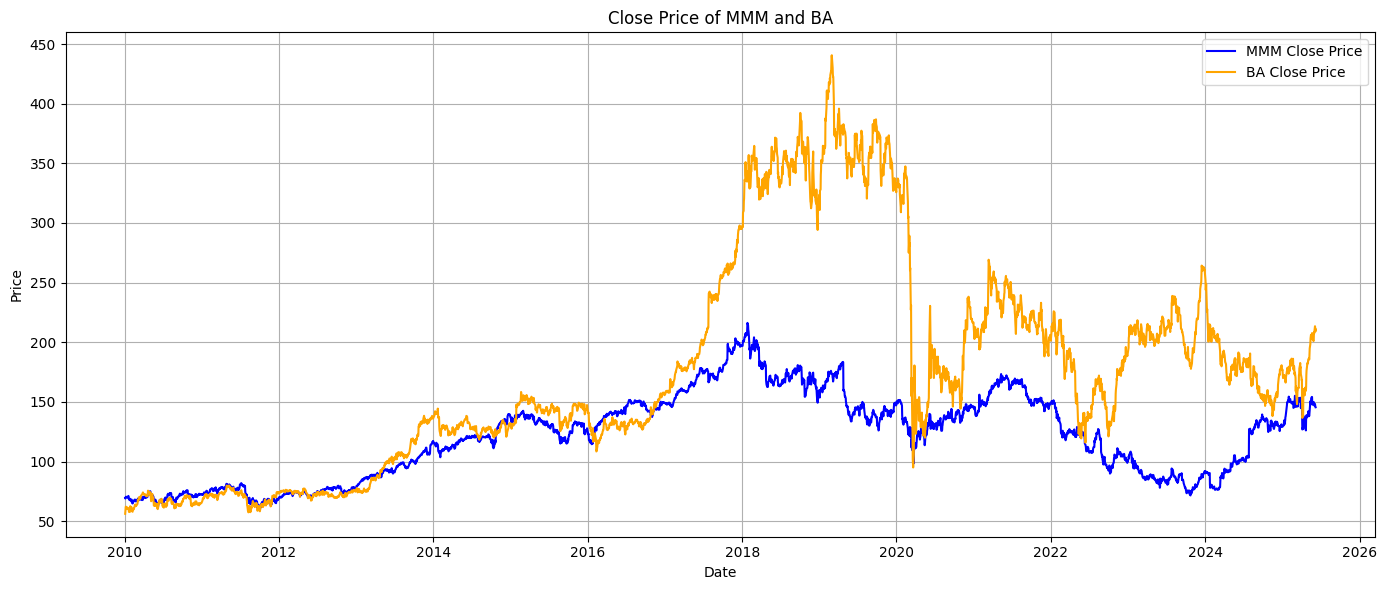

In [209]:
#plotting the close price of the two tickers
plt.figure(figsize=(14, 6))
plt.plot(myWorkingData['date'], myWorkingData[f'{ticker1}_close'], label=f'{ticker1} Close Price', color='blue')
plt.plot(myWorkingData['date'], myWorkingData[f'{ticker2}_close'], label=f'{ticker2} Close Price', color='orange')
plt.title(f'Close Price of {ticker1} and {ticker2}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

##### Order Management System


In [210]:
class OrderManagementSystem:
    def __init__(self,slippage=0.01, commission=0.001, constraints=None):
        #self.orders is an array of type orders classes)
        self.orders = []
        self.changeConstraints(constraints)
        self.slippage = slippage  # Percentage slippage on each order
        self.commission = commission  # Percentage commission on each order
        

    
    def changeConstraints(self, constraints):
        """
        Change the constraints of the order management system.
        """
        self.constraints = constraints
        self.stopLoss = constraints['stopLoss']
        self.takeProfit = constraints['takeProfit']
        self.shortOnly = constraints['shortOnly']
        self.longOnly = constraints['longOnly']
        self.holdingPeriod = constraints['holdingPeriod']
        print(f"✅ Constraints updated: {self.constraints}")
        
    def initWorkingData(self, columns):
        """
        Initialize the working data DataFrame with specified columns.
        Working data is used to store the results of the strategy execution
        and historical ticker data
        """
        self.workingData = pd.DataFrame(columns=columns)
        print("✅ Working data initialized with columns:", columns)
        
    def addRow (self, row):
        """
        Add a row to the working data DataFrame.
        """
        self.workingData = pd.concat([self.workingData, pd.DataFrame([row])], ignore_index=True)
        self.checkOpenOrders()
        
    def shouldLiquidate(self, order):
        """
        Check if an order should be liquidated based on stop loss or take profit conditions.
        """
        last_row = self.workingData.iloc[-1]
        ticker = order['ticker']
        
        if order['stopLoss'] is not None and last_row[f'{ticker}_close'] <= order['stopLossPrice']:
            print(f"❗ Liquidating {order['signal']} order for {ticker} due to stop loss.")
            self.liquidateOrder(order)
            return True
        
        if order['takeProfit'] is not None and last_row[f'{ticker}_close'] >= order['takeProfitPrice']:
            print(f"❗ Liquidating {order['signal']} order for {ticker} due to take profit.")
            self.liquidateOrder(order)
            return True
        
        return False
    
    def liquidateOrder(self, order):
        """
        Liquidate an order by removing it from the open orders list.
        This method can be called when a stop loss or take profit condition is met.
        Need to implement the logic to remove the order from the orders list.
        Need to implement the logic to update the working data with the liquidation details.
        Need to implement the logic to reverse order position in the working data.
        """
        print(f"✅ Liquidated order: {order}")
        
        # Update working data with liquidation details
        last_row = self.workingData.iloc[-1]
        ticker = order['ticker']
        orderPosition = order['position']
        # Adjust the position in workingData to reflect liquidation
        # Find the current position for the ticker in the last row
        current_position = last_row.get(f'{ticker}_position', 0)
        # Set the new position to zero (fully liquidated)
        newPosition = current_position - orderPosition +self.slippage + self.commission
        
        #update the working data with the new position
        self.workingData.at[last_row.name, f'{ticker}_position'] = newPosition
            
        
    def checkOpenOrders(self):
        """
        Check if there are any open orders that need to be executed.
        This method can be called after adding a new row to the working data.
        """
        if not self.orders:
            print("✅ No open orders to check.")
            return
        
        for order in self.orders:
            #a simple order is when stopLoss and takeProfit are None
            if order['stopLoss'] is None and order['takeProfit'] is None or order['expired']:
                continue
            
            self.shouldLiquidate(order)
            order['expired'] = True
        
    def addOrder(self, signal):
        finalOrder = self.ExecuteOrder(signal)
        if finalOrder is not None:
            self.orders.append(finalOrder)
        
    def calculateRollingMetrics(self, idx, ticker, position, return_of_stock, return_of_strategy, complex=False):
        if complex:
            self.workingData.at[idx, f'{ticker}_position'] = position
            self.workingData.at[idx, f'{ticker}_return_of_stock'] = return_of_stock
            self.workingData.at[idx, f'{ticker}_return_of_strategy'] = return_of_strategy
        else:
            self.workingData.at[idx, f'{ticker}_position'] = position
            self.workingData.at[idx, f'{ticker}_return_of_stock'] = return_of_stock
            self.workingData.at[idx, f'{ticker}_return_of_strategy'] = return_of_strategy
            
        # Add rolling metrics
        window = 20 
        
        if len(self.workingData) >= window:
            recent = self.workingData.iloc[-window:]
            sharpe = (
                recent[f'{ticker}_return_of_strategy'].mean() /
                recent[f'{ticker}_return_of_strategy'].std()
                if recent[f'{ticker}_return_of_strategy'].std() != 0 else np.nan
            )
            volatility = recent[f'{ticker}_return_of_strategy'].std()
            cov = recent[[f'{ticker}_return_of_strategy', f'{ticker}_return_of_stock']].cov().iloc[0, 1]
            var_stock = recent[f'{ticker}_return_of_stock'].var()
            beta = cov / var_stock if var_stock != 0 else np.nan

            self.workingData.at[idx, f'{ticker}_rolling_sharpe'] = sharpe
            self.workingData.at[idx, f'{ticker}_rolling_volatility'] = volatility
            self.workingData.at[idx, f'{ticker}_rolling_beta'] = beta
    
        
            
    def executeOrder(self, Signal):
        signal = Signal['signal']
        ticker = Signal['ticker']
        
        if signal != 'close':
            #checking for long or short only constraints
            if self.longOnly and signal == 'sell':
                print("❌ Long only constraint violated. Cannot execute sell order.")
                return None
            if self.shortOnly and signal == 'buy':
                print("❌ Short only constraint violated. Cannot execute buy order.")
                return None
        
        
        last_row = self.workingData.iloc[-1]
        confidence = Signal.get('confidence', 1)
        if signal== 'close':
            confidence = 1
        position = ((confidence * (1 if signal == 'buy' else -1)) * (1-(self.slippage+self.commission))) if signal != 'close' else 0
        
        return_of_stock = last_row[f'{ticker}_close'] / last_row[f'{ticker}_open'] - 1
        return_of_strategy = return_of_stock * position

        idx = last_row.name
        
        self.calculateRollingMetrics(idx, ticker,position,  return_of_stock, return_of_strategy)
        if self.stopLoss is not None:
            stopLossPrice = last_row[f'{ticker}_open'] * (1 - self.stopLoss) if signal == 'buy' else last_row[f'{ticker}_open'] * (1 + self.stopLoss)
            expired = False
        else:
            stopLossPrice = None
            expired = True
        if self.takeProfit is not None:
            takeProfitPrice = last_row[f'{ticker}_open'] * (1 + self.takeProfit) if signal == 'buy' else last_row[f'{ticker}_open'] * (1 - self.takeProfit)
            expired = False
        else:
            takeProfitPrice = None
            expired = True
        order = {
            'ticker': ticker,
            'signal': signal,
            'position': position,
            'confidence': confidence,
            'idx': idx,
            'stopLoss': self.stopLoss,
            'takeProfit': self.takeProfit,
            'stopLossPrice': stopLossPrice,
            'takeProfitPrice': takeProfitPrice,
            'expired': expired,
        }
        return order
        
            
        
    def ExecuteOrder(self, signal):
        order = self.executeOrder(signal)
        if order is not None:
            return order
        else:
            return None
        
        
        
        
    
    

##### Backtesting.py


In [181]:
class SMAStrategy(MyStrategy):
    def __init__(self, data, name="Mean Reversion Strategy", description="A strategy that trades based on mean reversion principles.", constraints=None, window = 30):
        super().__init__(data, name, description, constraints)
        self.window = window
        
    def createProcessedData(self):
        """
        Combines two ticker DataFrames into a single DataFrame with renamed columns.
        Processes the data to:
        1. Remove time component from dates
        2. Ensure both datasets have data up to 2025-06-06
        3. Join on date with column renaming (ticker_columnName format)
        """
        # Get the ticker names from the first row of rawData in the symbols Column
        columnName = 'symbol'
        #getting the value of the first row of the symbols column
        self.ticker = self.rawData[columnName].iloc[0]
        
        #setting all the column names to {ticker}_columnName from the rawData into the workingData
        self.data = self.rawData.rename(columns=lambda x: f"{self.ticker}_{x}" if x != columnName else x)
        
        
        #resetting the index data the rawData so that we can access the date column
        self.data = self.data.reset_index()
        self.data['date'] = pd.to_datetime(self.data['date']).dt.date
        
        
        #
        
        
        
        
        #set the columns of the workingData to the columns of the rawData
        
        self.workingData = pd.DataFrame(columns=self.data.columns)
        
        #initializing the workingData in oms with the rawData columns
        self.oms.initWorkingData(self.data.columns)
        pass
        
        
        # Optional: Set date as index if needed
        # self.workingData.set_index('date', inplace=True)
        
        
        
    def go(self):
        """
        This method should be implemented by subclasses to define the trading logic.
        It will be called to execute the strategy.
        """
        for index, row in self.data.iterrows():
            print(f"Processing row {index} for Mean Reversion Strategy")
            self.processRow(row)
            
            
    def updateWorkingData(self, row):
        """
        Updates the working data with the current row.
        This method is called for each row in the DataFrame.
        """
        # Append the current row to the working data
        self.workingData = pd.concat([self.workingData, pd.DataFrame([row])], ignore_index=True)
        self.updateWorkingDataMetrics()
        self.oms.addRow(row)
        
    def updateWorkingDataMetrics(self):
        """
        Updates working data with mean reversion metrics:
        1. Price ratio between the two tickers
        2. Rolling mean and std of the ratio (100-day window)
        3. Z-Score of current ratio
        4. Upper/lower bounds (mean ± 2*std)
        """
        if len(self.workingData) < 2:
            return  # Need at least 2 data points
        
        # Get ticker names (assuming they're stored or can be extracted)
        ticker= self.ticker
        
        # Only calculate rolling metrics if we have enough data
        # if len(self.workingData) >= self.window:
        #     # Calculate rolling statistics (self.window-day window)
        #     self.workingData['ratio_mean'] = self.workingData['price_ratio'].rolling(self.window).mean()
        #     self.workingData['ratio_std'] = self.workingData['price_ratio'].rolling(self.window).std()
            
        #     # Calculate Z-Score
        #     self.workingData['z_score'] = (
        #         (self.workingData['price_ratio'] - self.workingData['ratio_mean']) / 
        #         self.workingData['ratio_std']
        #     )
            
        #     # Calculate Bollinger-band like thresholds
        #     self.workingData['upper_bound'] = self.workingData['ratio_mean'] + 2*self.workingData['ratio_std']
        #     self.workingData['lower_bound'] = self.workingData['ratio_mean'] - 2*self.workingData['ratio_std']
        
        # Calculate additional metrics (your existing implementation)
        #self.calculateAdditionalMetrics()
    
    
    def processRow(self, row, type='EOD'):
        """
        This method should be implemented by subclasses to define how each row of data is processed.
        It will be called for each row in the DataFrame.
        """
        #check if the working data has at least self.window rows
        if not len(self.workingData) < self.window:
            # Calculate signal using only past data
            signal1 = self.calculateSignal()
            
            if signal1:
                self.oms.addOrder(signal1)
            
        
        
        
        # Append the current row to the working data
        self.updateWorkingData(row)
        
    def calculateSignal(self):
        """
        Generates signals for Ticker1 based on mean reversion of the price ratio.
        Returns: dict or None
        """
        if len(self.workingData) < self.window:
            return None
        
        ## if the 10 day moving average is greater than the 20 day moving average, then we have a buy signal, otherwise sell
        ma1 = self.workingData[f'{self.ticker}_close'].rolling(window=10).mean().iloc[-1]
        ma2 = self.workingData[f'{self.ticker}_close'].rolling(window=20).mean().iloc[-1]
        
        
        if ma1 > ma2:
            # Ticker1 is in an uptrend → BUY signal
            return {
                'ticker': self.ticker,
                'signal': 'buy',
                'price': self.workingData[f'{self.ticker}_close'].iloc[-1],
                'type': 'sma'
            }
        elif ma1 < ma2:
            # Ticker1 is in a downtrend → SELL signal
            return {
                'ticker': self.ticker,
                'signal': 'sell',
                'price': self.workingData[f'{self.ticker}_close'].iloc[-1],
                'type': 'sma'
            }
        return None
     
    def orderManagement(self):
        """
        This method should be implemented by subclasses to define how orders are managed based on signals.
        It will be called when a signal is generated.
        """
        pass
    
    
    def plotMetrics(self):
        """
        This method should be implemented by subclasses to convert the data to End of Day (EOD) format.
        It will be called to preprocess the data before running the strategy.
        """
        pass
    
    
    def returnMetrics(self):
        """
        This method should be implemented by subclasses to return the metrics of the strategy.
        It will be called to retrieve the performance metrics after running the strategy.
        """
        pass
        
    

In [189]:
ticker1 = 'GOOG'


# Fetching EOD data for the two tickers
df1 = pg.getTickerEODData(ticker1)


# Initialize and run the Mean Reversion Strategy
data=df1

constraints = {
    'holdingPeriod': None,
    'stopLoss': 0.8,
    'takeProfit': None,
    'longOnly': False,
    'shortOnly': False,
}
strategy = SMAStrategy(name = f"{ticker1}_{ticker2}_MeanReversion",data=data, constraints=constraints)
strategy.go()

✅ Retrieved 5234 rows of EOD data for GOOG
✅ Constraints updated: {'holdingPeriod': None, 'stopLoss': 0.8, 'takeProfit': None, 'longOnly': False, 'shortOnly': False}
✅ Working data initialized with columns: Index(['date', 'symbol', 'GOOG_open', 'GOOG_close', 'GOOG_volume'], dtype='object')
Processing row 0 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 1 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 2 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 3 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 4 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 5 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 6 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 7 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 8 for Mean Reversion Strategy
✅ No open orders to check.
Processing row 9 for Mean Reversion Strategy
✅ No open orders

/tmp/ipykernel_1467/1538269411.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.workingData = pd.concat([self.workingData, pd.DataFrame([row])], ignore_index=True)
/tmp/ipykernel_1467/1611334307.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.workingData = pd.concat([self.workingData, pd.DataFrame([row])], ignore_index=True)


Processing row 90 for Mean Reversion Strategy
Processing row 91 for Mean Reversion Strategy
Processing row 92 for Mean Reversion Strategy
Processing row 93 for Mean Reversion Strategy
Processing row 94 for Mean Reversion Strategy
Processing row 95 for Mean Reversion Strategy
Processing row 96 for Mean Reversion Strategy
Processing row 97 for Mean Reversion Strategy
Processing row 98 for Mean Reversion Strategy
Processing row 99 for Mean Reversion Strategy
Processing row 100 for Mean Reversion Strategy
Processing row 101 for Mean Reversion Strategy
Processing row 102 for Mean Reversion Strategy
Processing row 103 for Mean Reversion Strategy
Processing row 104 for Mean Reversion Strategy
Processing row 105 for Mean Reversion Strategy
Processing row 106 for Mean Reversion Strategy
Processing row 107 for Mean Reversion Strategy
Processing row 108 for Mean Reversion Strategy
Processing row 109 for Mean Reversion Strategy
Processing row 110 for Mean Reversion Strategy
Processing row 111 for 

📈 Sharpe Ratio for full period: 0.03


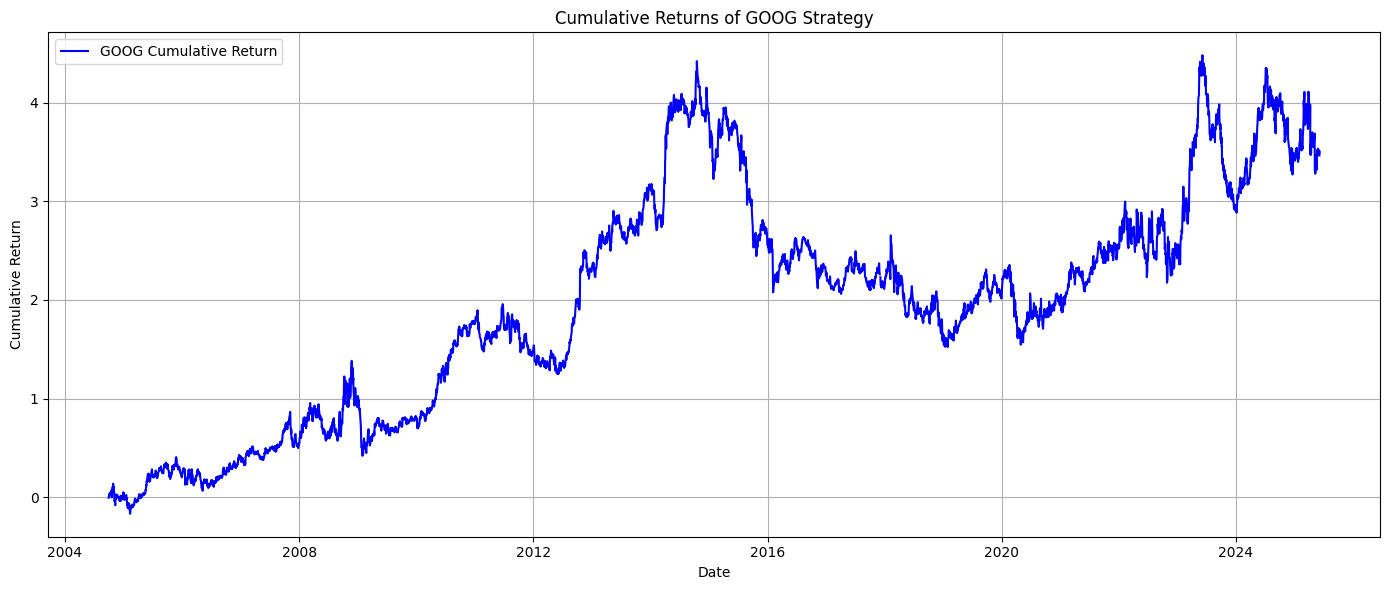

In [192]:
myWorkingData = strategy.oms.workingData.copy()

myWorkingData.tail(10)

#getting the geometric returns of the stocks
#plotting the cumulative returns from 2004-08-19 to 2013-03-01
myWorkingData['GOOG_cumulative'] = (1 + myWorkingData['GOOG_return_of_strategy']).cumprod() - 1
#calculate the geometric rolling cumulative strategy_return
# Plot the cumulative returns
plt.figure(figsize=(14, 6))
plt.plot(myWorkingData['date'], myWorkingData['GOOG_cumulative'], label='GOOG Cumulative Return', color='blue')
plt.title('Cumulative Returns of GOOG Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.tight_layout()

#printing the sharpe for the whole period
sharpe = myWorkingData['GOOG_return_of_strategy'].mean() / myWorkingData['GOOG_return_of_strategy'].std()
print(f"📈 Sharpe Ratio for full period: {sharpe:.2f}")


In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(GOOG, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()

GridPlot(id='p1725', ...)

In [186]:
stats

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                    94.27374
Equity Final [$]                  56263.51934
Equity Peak [$]                   56309.05934
Commissions [$]                   10563.95154
Return [%]                          462.63519
Buy & Hold Return [%]               607.37036
Return (Ann.) [%]                    22.46598
Volatility (Ann.) [%]                 37.4129
CAGR [%]                             14.99343
Sharpe Ratio                          0.60049
Sortino Ratio                          1.1445
Calmar Ratio                           0.6621
Alpha [%]                           450.62135
Beta                                  0.01978
Max. Drawdown [%]                   -33.93159
Avg. Drawdown [%]                    -6.16072
Max. Drawdown Duration      830 days 00:00:00
Avg. Drawdown Duration       50 days 00:00:00
# Trades                          

In [146]:
class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()
            
        print(f"Current date: {self.data.index[-1]}, MA1: {self.ma1[-1]}, MA2: {self.ma2[-1]}")


bt = Backtest(GOOG, SmaCross, commission=.002,
              exclusive_orders=True)

bt._results
# stats = bt.run()
# bt.plot()

In [131]:
stats.keys()

Index(['Start', 'End', 'Duration', 'Exposure Time [%]', 'Equity Final [$]',
       'Equity Peak [$]', 'Commissions [$]', 'Return [%]',
       'Buy & Hold Return [%]', 'Return (Ann.) [%]', 'Volatility (Ann.) [%]',
       'CAGR [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio',
       'Alpha [%]', 'Beta', 'Max. Drawdown [%]', 'Avg. Drawdown [%]',
       'Max. Drawdown Duration', 'Avg. Drawdown Duration', '# Trades',
       'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]', 'Avg. Trade [%]',
       'Max. Trade Duration', 'Avg. Trade Duration', 'Profit Factor',
       'Expectancy [%]', 'SQN', 'Kelly Criterion', '_strategy',
       '_equity_curve', '_trades'],
      dtype='object')

In [134]:
stats['_equity_curve'].tail()

,Equity,DrawdownPct,DrawdownDuration
2013-02-25,55199.53934,0.019704,NaT
2013-02-26,55155.37934,0.020488,NaT
2013-02-27,55821.22934,0.008663,NaT
2013-02-28,55919.20934,0.006923,NaT
2013-03-01,56263.51934,0.000809,10 days
